### Evaluating MMIDAS - Mouse smartseq data
This notebook guides you in evaluating MMIDAS in identifying meaningful cell types.

In [30]:
%load_ext autoreload
%autoreload 2

import warnings
import subprocess
import os
from os import path
import glob
import functools
from typing import Mapping, Any, Literal, Iterable, Sequence, Optional, Tuple

import numpy as np
import torch as th
from torch import nn
from torch.utils.data import DataLoader
from scipy.optimize import linear_sum_assignment
import seaborn as sns
import matplotlib.pyplot as plt


%matplotlib inline
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.metrics.cluster import adjusted_mutual_info_score
from sklearn.preprocessing import normalize
from tqdm import trange, tqdm


def run_cmd(cmd: str) -> str:
    return subprocess.check_output(cmd, shell=True).decode().strip()


def get_parentdirname(d: str) -> str:
    return path.basename(path.dirname(d))


def is_childdir(d: str, c: str) -> bool:
    return c in os.listdir(d)


def fix_dir(d: str) -> None:
    if os.getcwd().endswith(d):
        pass
    elif get_parentdirname(os.getcwd()) == d:
        os.chdir("..")
    elif is_childdir(os.getcwd(), d):
        os.chdir(d)


def dedup(xs: Iterable) -> Iterable:
    acc = []
    seen = set()
    for x in xs:
        if x not in seen:
            acc.append(x)
        seen.add(x)
    return acc


def unstable(func):
    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        warnings.warn(
            f"{func.__name__}() is unstable", category=FutureWarning, stacklevel=2
        )
        return func(*args, **kwargs)

    return wrapper


DIR = "distributed-vae"  # warning: change this if you change the name of the directory

fix_dir(DIR)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
import mmidas
from mmidas.nn_model import mixVAE_model, mk_vae
from mmidas.utils.tree_based_analysis import get_merged_types
from mmidas.cpl_mixvae import cpl_mixVAE, unwrap, to_np
from mmidas.utils.tools import get_paths
from mmidas.utils.dataloader import load_data, get_loaders
from mmidas.utils.cluster_analysis import K_selection
from mmidas.eval_models import summarize_inference
from mmidas.model import generate, load_vae
from mmidas._utils import (
    compute_confmat,
    confmat_normalize,
    parse_epoch,
    reassign,
    compute_consensus_statistics,
)
from mmidas._evals import evals2

In [3]:
MouseSmartSeq = Literal["mouse_smartseq"]
Mouse10x = Literal["TODO"]
SeattleAlzheimer = Literal["TODO"]

Dataset = MouseSmartSeq | Mouse10x | SeattleAlzheimer

dataset = "mouse_smartseq"
config: Mapping[str, Any] = get_paths("mmidas.toml", dataset)
data: Mapping[str, Any] = load_data(
    config[dataset]["data_path"] / config[dataset]["anndata_file"]
)
dedup(type(v) for v in data.values())

/allen/programs/celltypes/workgroups/mousecelltypes/Hilal/distributed-vae/mmidas.toml
Getting files directories belong to mouse_smartseq...


/home/hilal.mufti/Hilal/distributed-vae/.venv/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


AnnData object with n_obs × n_vars = 22365 × 5032
    obs: 'sample_name', 'sample_id', 'seq_batch', 'sex', 'brain_hemisphere', 'brain_region', 'brain_subregion', 'class', 'subclass', 'cluster', 'confusion_score'
 --------- Data Summary --------- 
# cell types: 115 | # cells: 22365 | # genes: 5032


[numpy.matrix, numpy.ndarray, pandas.core.arrays.categorical.Categorical, int]

In [4]:
def get_trained_models(f: str) -> Sequence[str]:
    return glob.glob(f + "/model/cpl_mixVAE_model_before**")


trained_model_folder = config[dataset]["trained_model"]
saving_folder = str(
    config["paths"]["main_dir"] / config[dataset]["saving_path"] / trained_model_folder
)
trained_models = get_trained_models(saving_folder)
selected_model = trained_models[0]
selected_model

IndexError: list index out of range

##### Construct a cpl-mixVAE object and load the trained_model.

In [5]:
# TODO: just parse the file name to get these params

n_categories = 92  # upper bound of number of categories (clusters)
state_dim = 2  # continuous (state) variable dimensionality
n_arm = 3  # number of arms
latent_dim = 10  # latent dimensionality of the model
train_loader, test_loader, all_loader = get_loaders(
    dataset=data["log1p"], batch_size=5000, seed=546
)

# cplMixVAE = cpl_mixVAE(saving_folder=saving_folder, device='cpu')
# cplMixVAE.init_model(n_categories=n_categories,
#                      state_dim=state_dim,
#                      input_dim=data['log1p'].shape[1],
#                      lowD_dim=latent_dim,
#                      n_arm=n_arm)
# cplMixVAE.variational = False

In [6]:
trainer = cpl_mixVAE(saving_folder=saving_folder, device="cuda")
trainer.init_model(
    n_categories=n_categories,
    state_dim=state_dim,
    input_dim=data["log1p"].shape[1],
    lowD_dim=latent_dim,
    n_arm=n_arm,
)

using cuda: NVIDIA A100-PCIE-40GB


## Model selection

##### Determining the sub-optimal number of clusters by leveraging consensus values across multiple pruning runs.
If you do not employ the pruning algorithm to determine the number of clusters, you can skip the following step.

In [ ]:
# Loading trained models including before pruning and after pruning
summary = summarize_inference(cplMixVAE, trained_models, train_loader)
summary.keys()

In [ ]:
# Plotting average consensus measure to select the number of clusters according to the minimum consensus measure, here 0.95

summary_file = saving_folder + f"/summary_performance_K_{n_categories}_narm_{n_arm}.p"
with open(summary_file, "rb") as f:
    summary_dict = np.load(f, allow_pickle=True)
f.close()

model_order = K_selection(summary_dict, n_categories, n_arm, thr=0.95)

Assessing the performance of the model for the chosen model order, which denotes the dimensionality of the categorical representation in the mixture VAE model.

In [ ]:
# selected_model = glob.glob(saving_folder + '/model/cpl_mixVAE_model_after_pruning_' + str(n_categories - model_order) + '*')[0]
model_order = n_categories
selected_model = glob.glob(saving_folder + "/model/cpl_mixVAE_model_before_**")[0]
outcome = summarize_inference(cplMixVAE, selected_model, train_loader)

In [9]:
@unstable
def evals(f: nn.Module, dl: DataLoader) -> Mapping[str, Any]:
    C = f.n_categories
    outs = generate(f, dl)

    preds = outs["preds"]
    inds_prune = outs["inds_prune"]
    pm = []
    emp_l2 = []
    emp_log = []
    consensus = []
    consensus_min = []
    consensus_mean = []
    dist_l2 = []
    dist_log = []
    for a, pred_a in tqdm(enumerate(preds)):
        for pred_b in preds[a + 1]:
            _pm = np.zeros((C, C))  # performance matrix for arm a vs arm b
            _emp_l2 = np.zeros((C, C))  # empirical matrix for arm a vs arm b
            _emp_log = np.zeros((C, C))  # empirical matrix for arm a vs arm b
            for samp_a, samp_b in zip(pred_a, pred_b):
                _pm[samp_a.astype(int) - 1, samp_b.astype(int) - 1] += 1
                _emp_l2[samp_a.astype(int) - 1, samp_b.astype(int) - 1] += np.sqrt(
                    np.sum((samp_a - samp_b) ** 2)
                )
                _emp_log[samp_a.astype(int) - 1, samp_b.astype(int) - 1] += 0.5 * (
                    samp_a * np.log(samp_a / samp_b) + samp_b * np.log(samp_b / samp_a)
                )

            smp_cts = []
            for c in range(C):
                smp_cts.append(max(_pm[c].sum(), _pm[:, c].sum()))
            smp_cts = np.array(smp_cts)

            inds_unpruned = np.where(np.isin(range(C), inds_prune) == False)[0]
            _consensus = np.divide(
                _pm, smp_cts, out=np.zeros_like(_pm), where=smp_cts != 0
            )[:, inds_unpruned][inds_unpruned]  # check this
            _dist_l2 = np.divide(
                _emp_l2, smp_cts, out=np.zeros_like(_emp_l2), where=smp_cts != 0
            )[:, inds_unpruned][inds_unpruned]
            _dist_log = np.divide(
                _emp_log, smp_cts, out=np.zeros_like(_emp_log), where=smp_cts != 0
            )[:, inds_unpruned][inds_unpruned]

            consensus.append(_consensus)
            consensus_min.append(np.min(np.diag(_consensus)))
            consensus_mean.append(
                1.0 - ((np.abs(preds[0] - preds[1]) > 0.0).sum() / preds.shape[1])
            )
            dist_l2.append(_dist_l2)
            dist_log.append(_dist_log)
            pm.append(_pm[inds_unpruned][:, inds_unpruned])
            emp_l2.append(_emp_l2[inds_unpruned][:, inds_unpruned])
            emp_log.append(_emp_log[inds_unpruned][:, inds_unpruned])

    return {
        "c_dists": outs["c_dists"],
        "c_l2_dists": outs["c_l2_dists"],
        "preds": outs["preds"],
        "inds_prune": outs["inds_prune"],
        "s_means": outs["s_means"],
        "s_logvars": outs["s_logvars"],
        "inds_x": outs["inds_x"],
        "cs": outs["cs"],
        "x_recs": outs["x_recs"],
        "x_lows": outs["x_lows"],
        "consensus": consensus,
        "consensus_min": consensus_min,
        "consensus_mean": consensus_mean,
        "pm": pm,
        "inds_unpruned": inds_unpruned,
        "emp_l2": emp_l2,
        "emp_log": emp_log,
        "dist_l2": dist_l2,
        "dist_log": dist_log,
    }


def get_axis(axes: tuple[int, int, Optional[int]]) -> str:
    if axes[0] == "ttypes" and axes[1] == "ttypes":
        return "Ttypes classification"
    elif axes[2] is not None:
        return f"Arm {axes[0]} of {axes[1]}-arm MMIDAS, run {axes[2]}"
    else:
        return f"Arm {axes[0]} of {axes[1]}-arm MMIDAS"


def get_axis_save(axes: tuple[int, int, Optional[int]]) -> str:
    if axes[0] == "ttypes" and axes[1] == "ttypes":
        return "tt"
    elif axes[2] is not None:
        return f"{axes[0]}{axes[1]}{axes[2]}"
    else:
        return f"{axes[0]}{axes[1]}"

In [11]:
# 5-arms run3 kinda bad

A = 2
B = 2
ra = 4
rb = 5
vae_a = load_vae(A, ra, 500000, data["log1p"].shape[1])
vae_b = load_vae(B, rb, 500000, data["log1p"].shape[1])

ev = evals2(vae_a, vae_b, all_loader)
len(ev["consensus"]), len(ev["consensus_a"]), len(ev["consensus_b"])

run: K92_S2_AUGTrue_LR0.001_A2_B5000_E500000_Ep0_RUN4
trained_models: ['/allen/programs/celltypes/workgroups/mousecelltypes/Hilal/distributed-vae/mmidas-results/K92_S2_AUGTrue_LR0.001_A2_B5000_E500000_Ep0_RUN4/model/cpl_mixVAE_model_before_pruning_A2_2024-10-16-05-31-59.pth']
loading: /allen/programs/celltypes/workgroups/mousecelltypes/Hilal/distributed-vae/mmidas-results/K92_S2_AUGTrue_LR0.001_A2_B5000_E500000_Ep0_RUN4/model/cpl_mixVAE_model_before_pruning_A2_2024-10-16-05-31-59.pth
/allen/programs/celltypes/workgroups/mousecelltypes/Hilal/distributed-vae/mmidas-results/K92_S2_AUGTrue_LR0.001_A2_B5000_E500000_Ep0_RUN4/model/cpl_mixVAE_model_before_pruning_A2_2024-10-16-05-31-59.pth
trained_models: ['/allen/programs/celltypes/workgroups/mousecelltypes/Hilal/distributed-vae/mmidas-results/K92_S2_AUGTrue_LR0.001_A2_B5000_E500000_Ep0_RUN4/model/cpl_mixVAE_model_before_pruning_A2_2024-10-16-05-31-59.pth']
loading: /allen/programs/celltypes/workgroups/mousecelltypes/Hilal/distributed-vae/mm

/allen/programs/celltypes/workgroups/mousecelltypes/Hilal/distributed-vae/mmidas/model.py:179: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  load_weights(vae, get_weights(r,

(4, 1, 1)

In [ ]:
def plot_consensus_circ(
    a_vs_b: np.ndarray,
    axes: tuple[tuple[Arms, Arm, Optional[Run]], tuple[Arms, Arm, Optional[Run]]],
    savedir: Optional[str],
) -> None:
    assert a_vs_b.shape[0] == a_vs_b.shape[1]

    mtx = a_vs_b / np.max(a_vs_b)
    C = mtx.shape[0]  # number of clusters

    fig, axs = plt.subplots(1, 1, figsize=(10, 10))
    for l in trange(C):
        for col in range(C):
            axs.add_patch(
                plt.Circle(np.array([col, l]), radius=mtx[l, col], color="Navy")
            )
    axs.set_xlim([-0.5, C])
    axs.set_ylim([-0.5, C - 0.5])
    axs.invert_yaxis()
    axs.set_yticks([])
    axs.set_xticks([])
    axs.set_yticklabels([])
    axs.set_xticklabels([])
    plt.title("Consensus for |c|= " + str(a_vs_b.shape[0]), fontsize=24)
    axs.set_xlabel(get_axis(axes[0]), fontsize=20)
    axs.set_ylabel(get_axis(axes[1]), fontsize=20)
    fig.tight_layout()
    if savedir:
        plt.savefig(
            savedir
            + f"/consensus_circ_{get_axis_save(axes[0])}_vs_{get_axis_save(axes[1])}_K{C}.png",
            dpi=600,
        )


so_far = 0
so_far_a = 0
so_far_b = 0
for a in range(A):
    for b in range(B):
        plot_consensus_circ(
            ev["pm"][so_far],
            ((a, A, ra), (b, B, rb)),
            # None
            f"multiarm-results/{A}{B}",
        )
        so_far += 1

    for b in range(a + 1, A):
        plot_consensus_circ(
            ev["pm_a"][so_far_a],
            ((a, A, ra), (b, A, ra)),
            # None
            f"multiarm-results/{A}{B}",
        )
        so_far_a += 1

for a in range(B):
    for b in range(a + 1, B):
        plot_consensus_circ(
            ev["pm_b"][so_far_b],
            ((a, B, rb), (b, B, rb)),
            f"multiarm-results/{A}{B}",
            # None,
        )
        so_far_b += 1

In [29]:
stats_two

{'consensus': {'xs': {(3,
    4): array([0.36037424, 0.361685  , 0.36312067, 0.36515421]),
   (3, 5): array([0.32408643, 0.32955553, 0.33175218, 0.33786413]),
   (4, 5): array([0.33584525, 0.33705755, 0.33491198, 0.33564206]),
   (3, 3): array([0.72654378]),
   (4, 4): array([0.68645487]),
   (5, 5): array([0.71986802])},
  'stds': {(3, 4): np.float64(0.001773783539256366),
   (3, 5): np.float64(0.004935293435963634),
   (4, 5): np.float64(0.0007714462149191182),
   (3, 3): np.float64(0.0),
   (4, 4): np.float64(0.0),
   (5, 5): np.float64(0.0)},
  'means': {(3, 4): np.float64(0.3625835304057916),
   (3, 5): np.float64(0.33081456522908276),
   (4, 5): np.float64(0.3358642109525295),
   (3, 3): np.float64(0.7265437801734052),
   (4, 4): np.float64(0.6864548723490244),
   (5, 5): np.float64(0.7198680198378653)}},
 'l2': {'xs': {(3, 4): array([0.05483999, 0.05511843, 0.05321776, 0.05455843]),
   (3, 5): array([0.04701767, 0.04874134, 0.04744269, 0.04953189]),
   (4, 5): array([0.04852743,

In [25]:
stats_two = compute_consensus_statistics(2, [3, 4, 5], 500000)
stats_three = compute_consensus_statistics(3, [5, 6, 7], 500000)
stats_five = compute_consensus_statistics(5, [0, 1, 2], 500000)

/home/hilal.mufti/Hilal/distributed-vae/.venv/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


AnnData object with n_obs × n_vars = 22365 × 5032
    obs: 'sample_name', 'sample_id', 'seq_batch', 'sex', 'brain_hemisphere', 'brain_region', 'brain_subregion', 'class', 'subclass', 'cluster', 'confusion_score'
 --------- Data Summary --------- 
# cell types: 115 | # cells: 22365 | # genes: 5032
run: K92_S2_AUGTrue_LR0.001_A2_B5000_E500000_Ep0_RUN3
loading: /allen/programs/celltypes/workgroups/mousecelltypes/Hilal/distributed-vae/mmidas-results/K92_S2_AUGTrue_LR0.001_A2_B5000_E500000_Ep0_RUN3/model/cpl_mixVAE_model_before_pruning_A2_2024-10-16-02-13-36.pth
/allen/programs/celltypes/workgroups/mousecelltypes/Hilal/distributed-vae/mmidas-results/K92_S2_AUGTrue_LR0.001_A2_B5000_E500000_Ep0_RUN3/model/cpl_mixVAE_model_before_pruning_A2_2024-10-16-02-13-36.pth
loading: /allen/programs/celltypes/workgroups/mousecelltypes/Hilal/distributed-vae/mmidas-results/K92_S2_AUGTrue_LR0.001_A2_B5000_E500000_Ep0_RUN3/model/cpl_mixVAE_model_before_pruning_A2_2024-10-16-02-13-36.pth
run: K92_S2_AUGTrue_L

/allen/programs/celltypes/workgroups/mousecelltypes/Hilal/distributed-vae/mmidas/model.py:181: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  
/allen/programs/celltypes/workg

AnnData object with n_obs × n_vars = 22365 × 5032
    obs: 'sample_name', 'sample_id', 'seq_batch', 'sex', 'brain_hemisphere', 'brain_region', 'brain_subregion', 'class', 'subclass', 'cluster', 'confusion_score'
 --------- Data Summary --------- 
# cell types: 115 | # cells: 22365 | # genes: 5032
run: K92_S2_AUGTrue_LR0.001_A3_B5000_E500000_Ep0_RUN5
loading: /allen/programs/celltypes/workgroups/mousecelltypes/Hilal/distributed-vae/mmidas-results/K92_S2_AUGTrue_LR0.001_A3_B5000_E500000_Ep0_RUN5/model/cpl_mixVAE_model_before_pruning_A3_2024-10-16-02-13-29.pth
/allen/programs/celltypes/workgroups/mousecelltypes/Hilal/distributed-vae/mmidas-results/K92_S2_AUGTrue_LR0.001_A3_B5000_E500000_Ep0_RUN5/model/cpl_mixVAE_model_before_pruning_A3_2024-10-16-02-13-29.pth
loading: /allen/programs/celltypes/workgroups/mousecelltypes/Hilal/distributed-vae/mmidas-results/K92_S2_AUGTrue_LR0.001_A3_B5000_E500000_Ep0_RUN5/model/cpl_mixVAE_model_before_pruning_A3_2024-10-16-02-13-29.pth
run: K92_S2_AUGTrue_L

/allen/programs/celltypes/workgroups/mousecelltypes/Hilal/distributed-vae/mmidas/model.py:181: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  
/allen/programs/celltypes/workg

AnnData object with n_obs × n_vars = 22365 × 5032
    obs: 'sample_name', 'sample_id', 'seq_batch', 'sex', 'brain_hemisphere', 'brain_region', 'brain_subregion', 'class', 'subclass', 'cluster', 'confusion_score'
 --------- Data Summary --------- 
# cell types: 115 | # cells: 22365 | # genes: 5032
run: K92_S2_AUGTrue_LR0.001_A5_B5000_E500000_Ep0_RUN0
loading: /allen/programs/celltypes/workgroups/mousecelltypes/Hilal/distributed-vae/mmidas-results/K92_S2_AUGTrue_LR0.001_A5_B5000_E500000_Ep0_RUN0/model/cpl_mixVAE_model_epoch_160000.pth
/allen/programs/celltypes/workgroups/mousecelltypes/Hilal/distributed-vae/mmidas-results/K92_S2_AUGTrue_LR0.001_A5_B5000_E500000_Ep0_RUN0/model/cpl_mixVAE_model_epoch_160000.pth
loading: /allen/programs/celltypes/workgroups/mousecelltypes/Hilal/distributed-vae/mmidas-results/K92_S2_AUGTrue_LR0.001_A5_B5000_E500000_Ep0_RUN0/model/cpl_mixVAE_model_epoch_160000.pth


/allen/programs/celltypes/workgroups/mousecelltypes/Hilal/distributed-vae/mmidas/model.py:181: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  


run: K92_S2_AUGTrue_LR0.001_A5_B5000_E500000_Ep0_RUN1
loading: /allen/programs/celltypes/workgroups/mousecelltypes/Hilal/distributed-vae/mmidas-results/K92_S2_AUGTrue_LR0.001_A5_B5000_E500000_Ep0_RUN1/model/cpl_mixVAE_model_epoch_150000.pth
/allen/programs/celltypes/workgroups/mousecelltypes/Hilal/distributed-vae/mmidas-results/K92_S2_AUGTrue_LR0.001_A5_B5000_E500000_Ep0_RUN1/model/cpl_mixVAE_model_epoch_150000.pth
loading: /allen/programs/celltypes/workgroups/mousecelltypes/Hilal/distributed-vae/mmidas-results/K92_S2_AUGTrue_LR0.001_A5_B5000_E500000_Ep0_RUN1/model/cpl_mixVAE_model_epoch_150000.pth
run: K92_S2_AUGTrue_LR0.001_A5_B5000_E500000_Ep0_RUN2
loading: /allen/programs/celltypes/workgroups/mousecelltypes/Hilal/distributed-vae/mmidas-results/K92_S2_AUGTrue_LR0.001_A5_B5000_E500000_Ep0_RUN2/model/cpl_mixVAE_model_epoch_160000.pth
/allen/programs/celltypes/workgroups/mousecelltypes/Hilal/distributed-vae/mmidas-results/K92_S2_AUGTrue_LR0.001_A5_B5000_E500000_Ep0_RUN2/model/cpl_mixVA

/allen/programs/celltypes/workgroups/mousecelltypes/Hilal/distributed-vae/mmidas/_evals.py:13: FutureWarning: generate() is unstable
  outs_a = generate(fa, dl)
/allen/programs/celltypes/workgroups/mousecelltypes/Hilal/distributed-vae/mmidas/model.py:31: FutureWarning: mk_masks() is unstable
  pruning_mask, inds_prune = mk_masks(f.fcc[0].bias)
100%|██████████| 5/5 [00:02<00:00,  1.73it/s]
/allen/programs/celltypes/workgroups/mousecelltypes/Hilal/distributed-vae/mmidas/_evals.py:14: FutureWarning: generate() is unstable
  outs_b = generate(fb, dl)
  0%|          | 0/5 [00:00<?, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fcc4c1e2480>
Traceback (most recent call last):
  File "/home/hilal.mufti/Hilal/distributed-vae/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/home/hilal.mufti/Hilal/distributed-vae/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", li

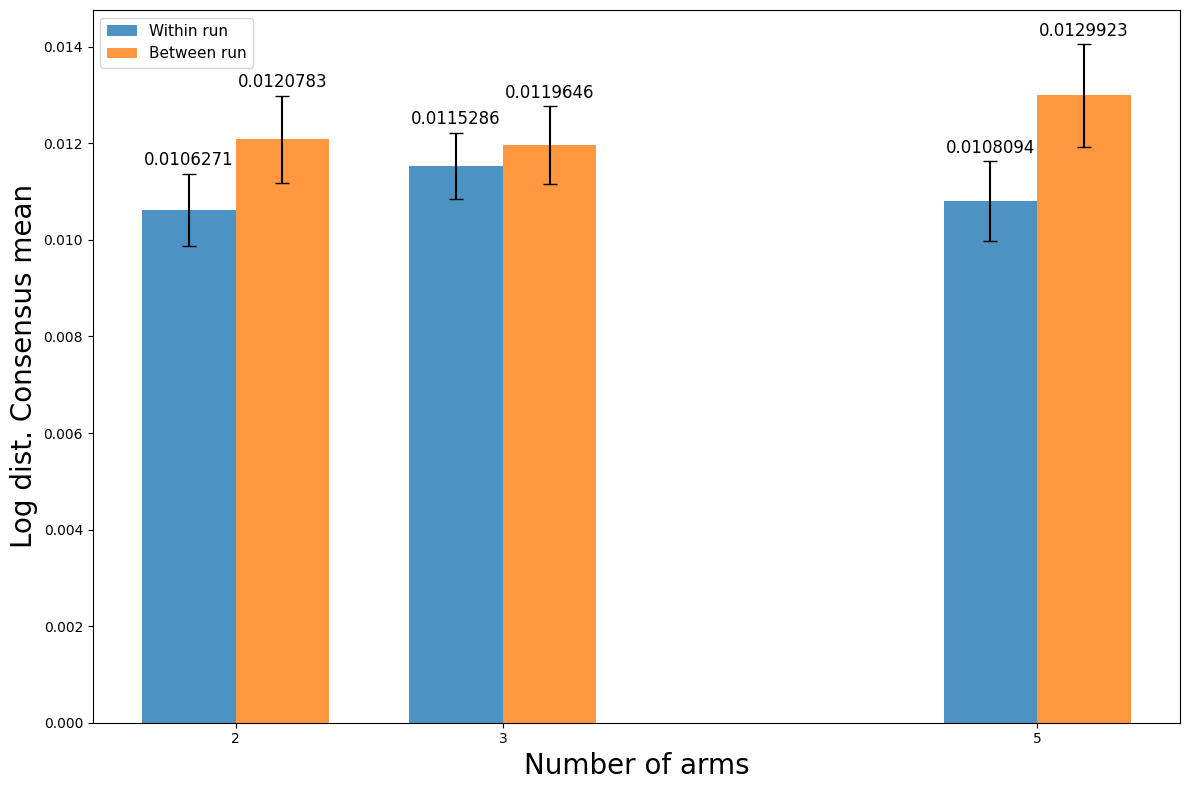

In [41]:
def plot_consensus_statistics(
    stats: Mapping[
        int, Tuple[Tuple[np.ndarray, np.ndarray], Tuple[np.ndarray, np.ndarray]]
    ],
    savedir: Optional[str],
) -> None:
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    
    x = list(stats.keys())
    width = 0.35  # width of the bars
    
    within_means = [v[0][0] for v in stats.values()]
    within_stds = [v[0][1] for v in stats.values()]
    between_means = [v[1][0] for v in stats.values()]
    between_stds = [v[1][1] for v in stats.values()]
    
    # Plot within-run bars
    rects1 = ax.bar(np.array(x) - width/2, within_means, width, yerr=within_stds,
                    label='Within run', capsize=5, alpha=0.8)
    
    # Plot between-run bars
    rects2 = ax.bar(np.array(x) + width/2, between_means, width, yerr=between_stds,
                    label='Between run', capsize=5, alpha=0.8)
    
    ax.set_xlabel("Number of arms", fontsize=20)
    ax.set_ylabel("Log dist. Consensus mean", fontsize=20)
    ax.set_xticks(x)
    ax.set_xticklabels(x)
    ax.legend(fontsize=11)
    
    ax.bar_label(rects1, padding=3, fontsize=12)
    ax.bar_label(rects2, padding=3, fontsize=12)
    
    fig.tight_layout()
    
    if savedir:
        plt.savefig(savedir + "/consensus_statistics_bar.png", dpi=600)


stats = {
    2: (
        (stats_two["total"]["within_run"]["log/mean"], stats_two["total"]["within_run"]["log/std"]),
        (stats_two["total"]["between_run"]["log/mean"], stats_two["total"]["between_run"]["log/std"]),
    ),
    3: (
        (stats_three["total"]["within_run"]["log/mean"], stats_three["total"]["within_run"]["log/std"]),
        (stats_three["total"]["between_run"]["log/mean"], stats_three["total"]["between_run"]["log/std"]),
    ),
    5: (
        (stats_five["total"]["within_run"]["log/mean"], stats_five["total"]["within_run"]["log/std"]),
        (stats_five["total"]["between_run"]["log/mean"], stats_five["total"]["between_run"]["log/std"]),
    ),
}

plot_consensus_statistics(
    stats,
    # None
    None,
)

avg consensus on test cells: 0.335845 (arm 0, run 4) vs (arm 0, run 5)
average L2 distance: 0.04852742500580079 (arm 0 run 4) , (arm 0 run 5)
average log distance: 0.011404977263928983 (arm 0 run 4), (arm 0 run 5)
avg consensus on test cells: 0.337058 (arm 0, run 4) vs (arm 1, run 5)
average L2 distance: 0.050718392528972256 (arm 0 run 4) , (arm 1 run 5)
average log distance: 0.012812884024049205 (arm 0 run 4), (arm 1 run 5)
avg consensus on test cells: 0.686455 (arm 0, run 4) vs (arm 1, run 4)
average L2 distance: 0.029592112904672972 (arm 0 run 4) , (arm 1 run 4)
average log distance: 0.024960887996355464 (arm 0 run 4), (arm 1 run 4)
avg consensus on test cells: 0.334912 (arm 1, run 4) vs (arm 0, run 5)
average L2 distance: 0.04942699424374768 (arm 1 run 4) , (arm 0 run 5)
average log distance: 0.011673373537849068 (arm 1 run 4), (arm 0 run 5)
avg consensus on test cells: 0.335642 (arm 1, run 4) vs (arm 1, run 5)
average L2 distance: 0.05120492778685452 (arm 1 run 4) , (arm 1 run 5)


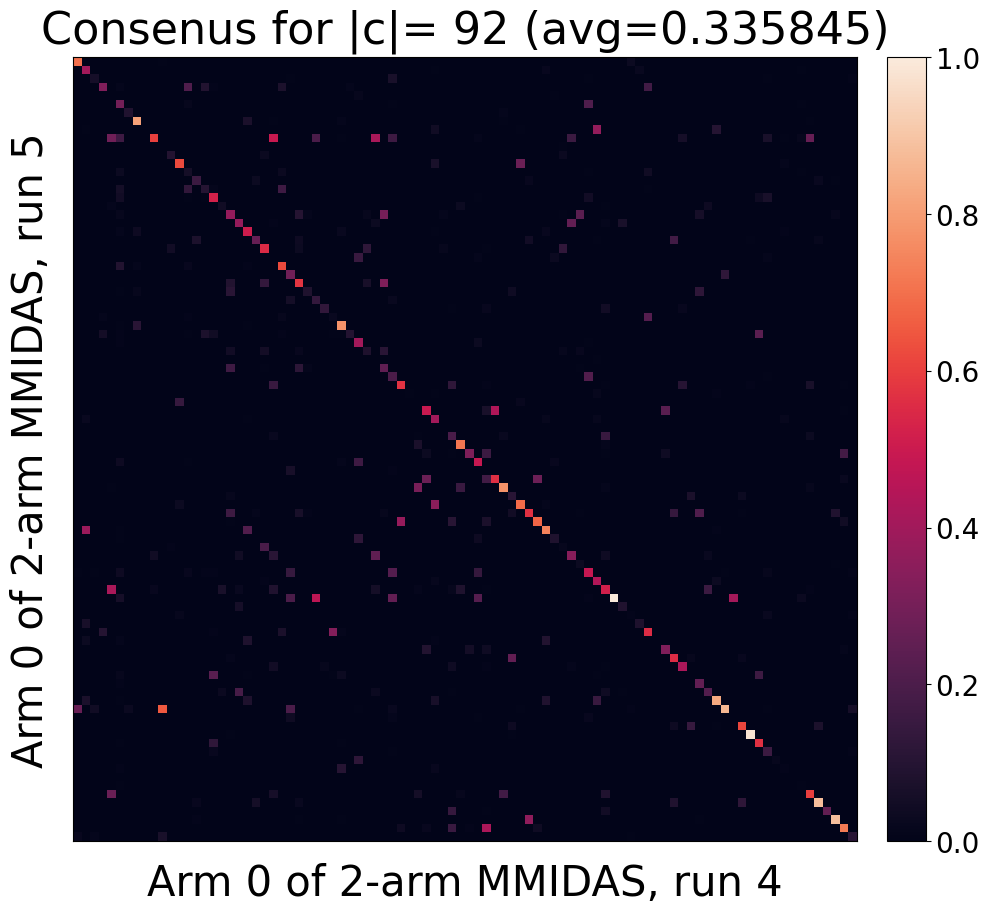

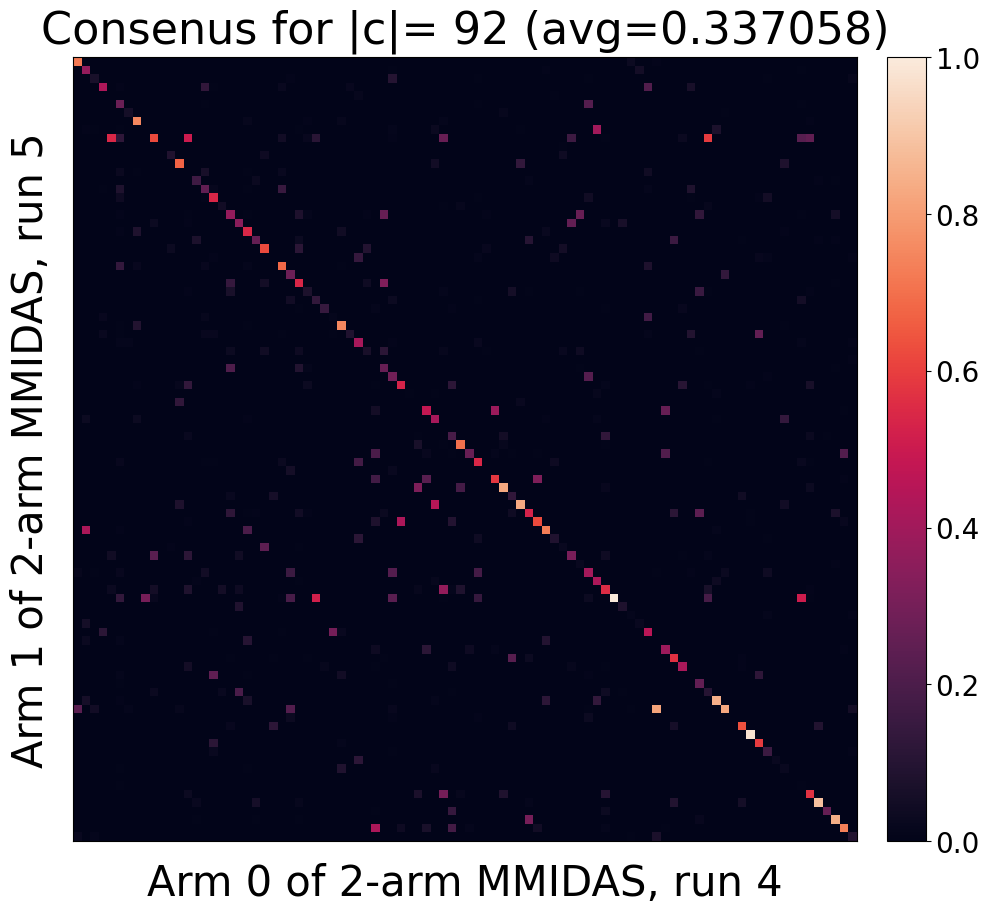

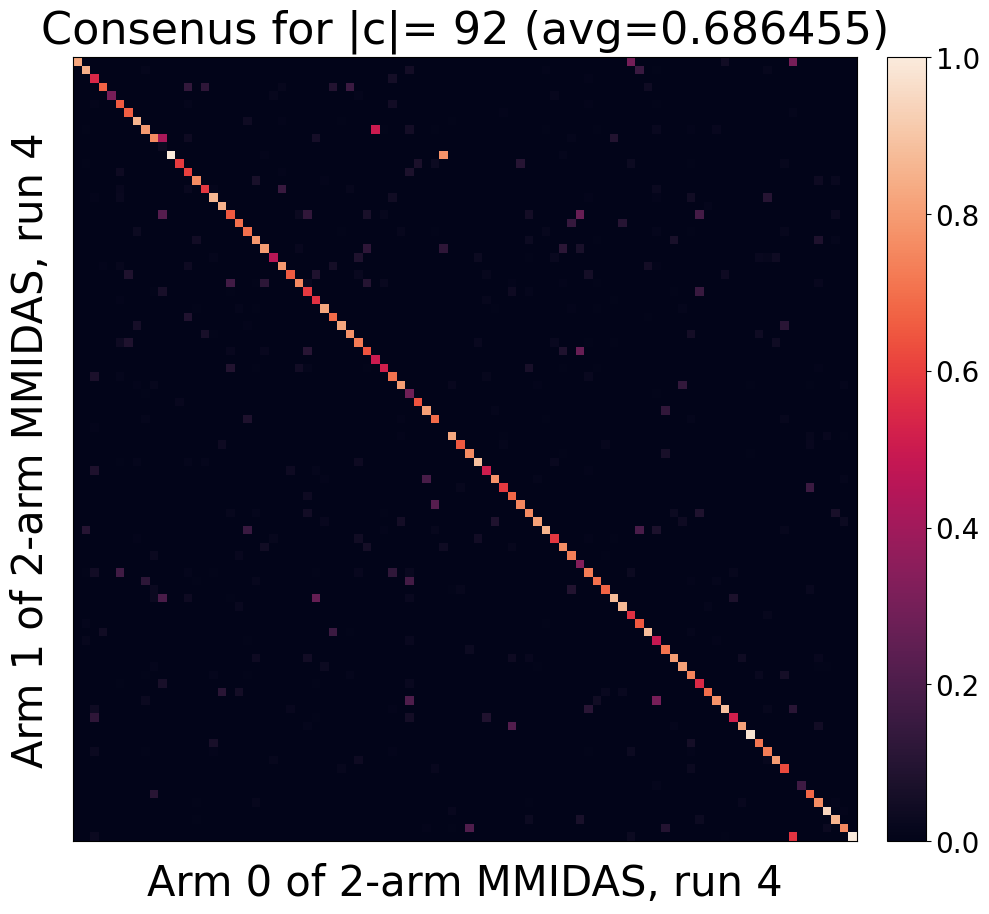

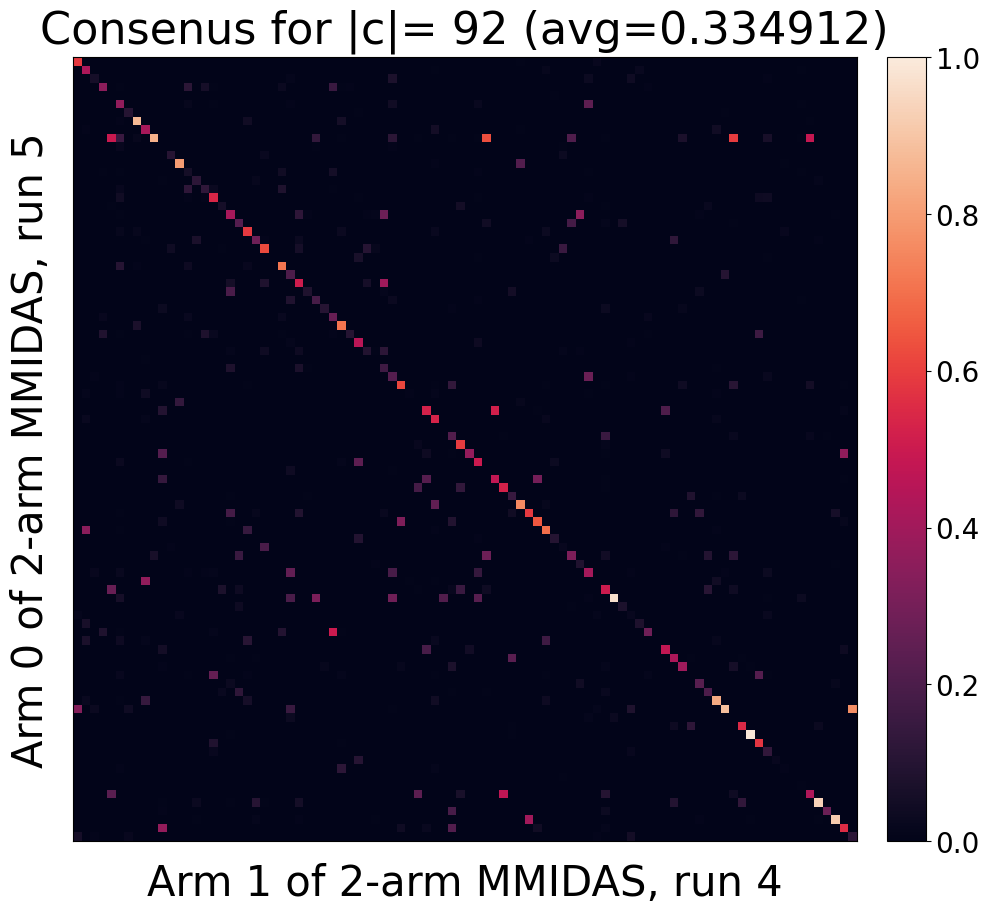

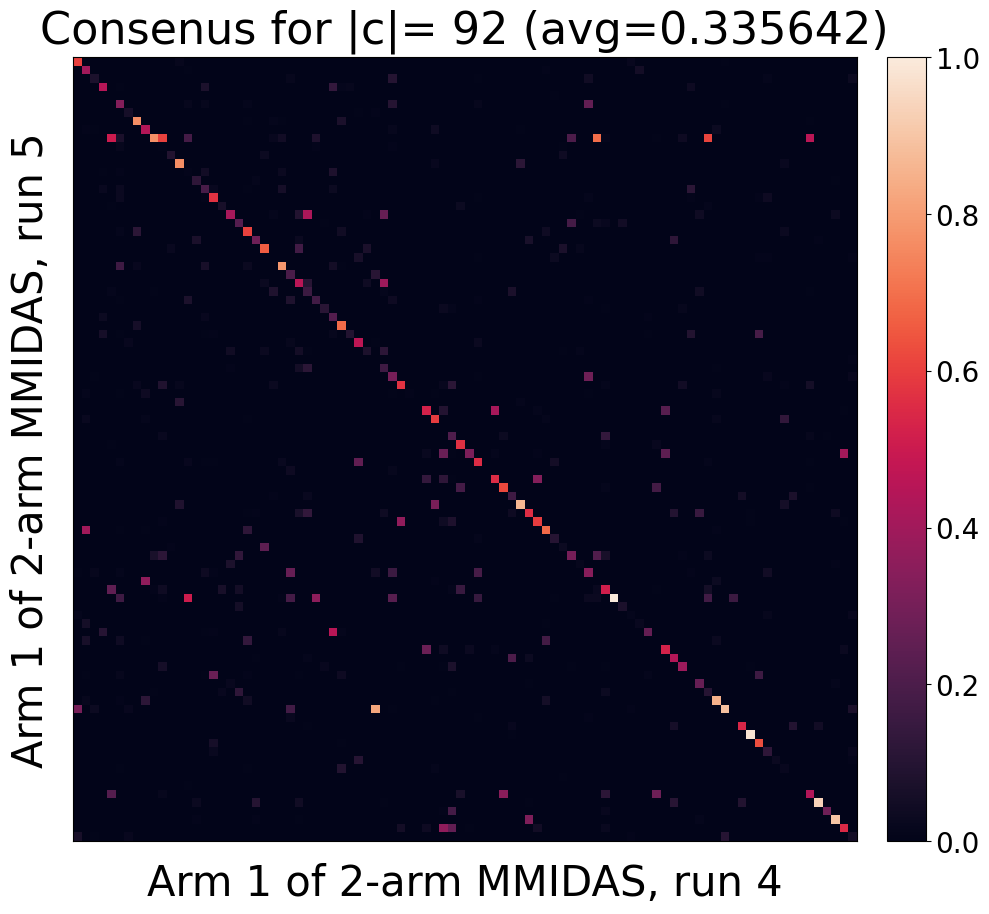

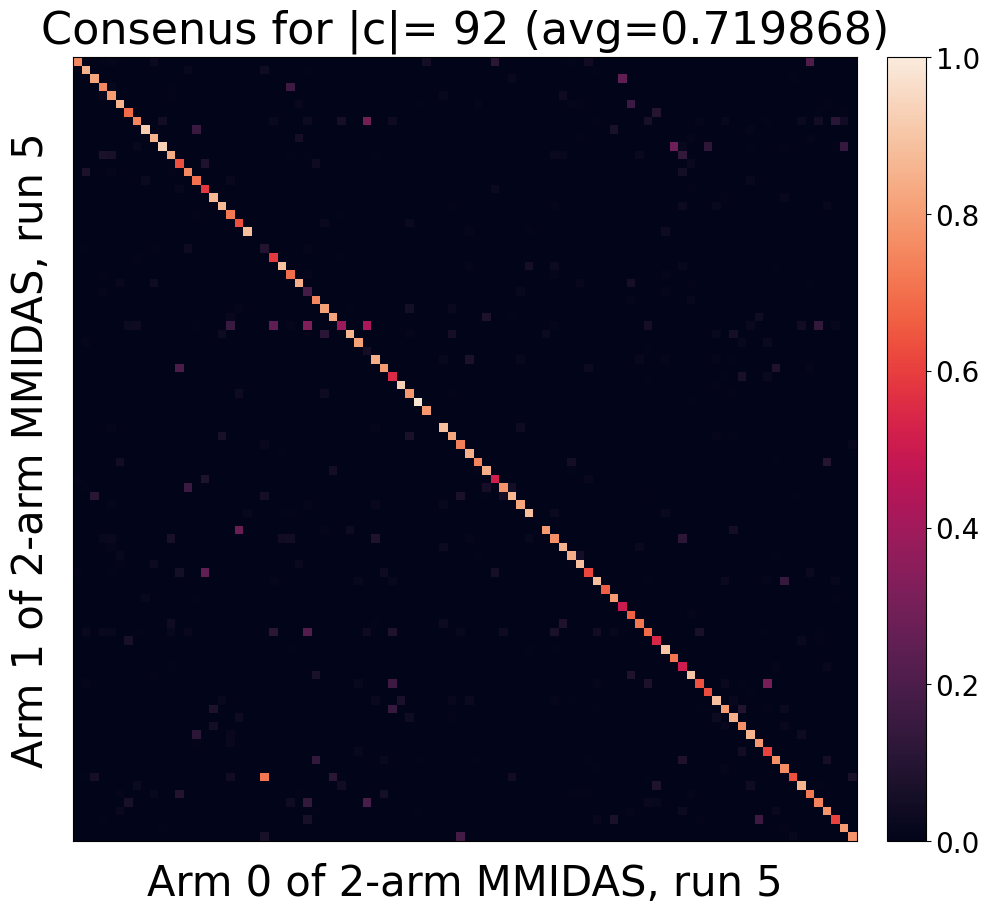

In [13]:
ConsensusMatrix = np.ndarray


def matched_mean(x):
    return np.mean(np.diag(reassign(x)))


def plot_consensus_heatmap(
    cm: ConsensusMatrix,
    axes: tuple[tuple[int, int, Optional[int]], tuple[int, int, Optional[int]]],
    savedir: Optional[str],
    between_runs,
    same_runs,
) -> None:
    (arma, armsa, runa), (armb, armsb, runb) = axes
    assert armsa == armsb

    _, col_inds = linear_sum_assignment(-cm)
    cm = cm[:, col_inds]

    plt.figure(figsize=[10, 10])
    ax = plt.gca()
    im = ax.imshow(cm, cmap="rocket", vmin=0, vmax=1)
    plt.xlabel(get_axis(axes[0]), fontsize=30, labelpad=15)
    plt.ylabel(get_axis(axes[1]), fontsize=30, labelpad=15)
    plt.xticks([])
    plt.yticks([])
    plt.title(
        f"Consenus for |c|= {str(cm.shape[0])} (avg={np.mean(np.diag(cm)):.6f})",
        fontsize=32,
        pad=10,
    )
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.3)
    cbar = plt.colorbar(im, cax=cax)
    for t in cbar.ax.get_yticklabels():
        t.set_fontsize(20)

    plt.tight_layout()
    if savedir:
        plt.savefig(
            savedir
            + f"/consensus_heat_{get_axis_save(axes[0])}_vs_{get_axis_save(axes[1])}_K{cm.shape[0]}.png",
            dpi=600,
        )
    avg_cons = np.mean(np.diag(cm))
    if runa == runb:
        same_runs.append(avg_cons)
    else:
        between_runs.append(avg_cons)
    print(
        f"avg consensus on test cells: {avg_cons:.6f} (arm {arma}, run {runa}) vs (arm {armb}, run {runb})"
    )


so_far = 0
so_far_a = 0
so_far_b = 0
between_runs = []
same_runs = []
between_runs_l2 = []
same_runs_l2 = []
between_runs_log = []
same_runs_log = []

for a in range(A):
    for b in range(B):
        plot_consensus_heatmap(
            ev["consensus"][so_far],
            ((a, A, ra), (b, B, rb)),
            f"multiarm-results/{A}{B}",
            between_runs,
            same_runs,
            # None
        )
        between_runs_l2.append(matched_mean(ev["dist_l2"][so_far]))
        between_runs_log.append(matched_mean(ev["dist_log"][so_far]))
        print(
            f"average L2 distance: {between_runs_l2[-1]} (arm {a} run {ra}) , (arm {b} run {rb})"
        )
        print(
            f"average log distance: {between_runs_log[-1]} (arm {a} run {ra}), (arm {b} run {rb})"
        )
        so_far += 1

    for b in range(a + 1, A):
        plot_consensus_heatmap(
            ev["consensus_a"][so_far_a],
            ((a, A, ra), (b, A, ra)),
            f"multiarm-results/{A}{B}",
            between_runs,
            same_runs,
            # None
        )
        same_runs_l2.append(matched_mean(ev["dist_l2_a"][so_far_a]))
        same_runs_log.append(matched_mean(ev["dist_log_a"][so_far_a]))
        print(
            f"average L2 distance: {same_runs_l2[-1]} (arm {a} run {ra}) , (arm {b} run {ra})"
        )
        print(
            f"average log distance: {same_runs_log[-1]} (arm {a} run {ra}), (arm {b} run {ra})"
        )
        so_far_a += 1

for a in range(B):
    for b in range(a + 1, B):
        plot_consensus_heatmap(
            ev["consensus_b"][so_far_b],
            ((a, B, rb), (b, B, rb)),
            f"multiarm-results/{A}{B}",
            between_runs,
            same_runs,
            # None
        )
        same_runs_l2.append(matched_mean(ev["dist_l2_b"][so_far_b]))
        same_runs_log.append(matched_mean(ev["dist_log_b"][so_far_b]))
        print(
            f"average L2 distance: {same_runs_l2[-1]} (arm {a} run {rb}) , (arm {b} run {rb})"
        )
        print(
            f"average log distance: {same_runs_log[-1]} (arm {a} run {rb}), (arm {b} run {rb})"
        )
        so_far_b += 1

print()
print(f"Average consensus between runs: {np.mean(np.array(between_runs))}")
print(f"Average consensus within runs: {np.mean(np.array(same_runs))}")
print(
    f"Ratio of between within runs: {np.mean(np.array(between_runs)) / np.mean(np.array(same_runs))}"
)
print()
print(f"Average L2 distance between runs: {np.mean(np.array(between_runs_l2))}")
print(f"Average L2 distance within runs: {np.mean(np.array(same_runs_l2))}")
print(
    f"Ratio of between within runs: {np.mean(np.array(between_runs_l2)) / np.mean(np.array(same_runs_l2))}"
)
print()
print(f"Average log distance between runs: {np.mean(np.array(between_runs_log))}")
print(f"Average log distance within runs: {np.mean(np.array(same_runs_log))}")
print(
    f"Ratio of between within runs: {np.mean(np.array(between_runs_log)) / np.mean(np.array(same_runs_log))}"
)

#### Evaluating the model results against a taxonomy
It necessitate access to a taxonomy for the dataset. Some of the subsequent steps depend on this taxonomy.

In [ ]:
# Loading the taxonomy tree and ordering the clusters according to the tree
htree_file = config[dataset]["data_path"] / config[dataset]["htree_file"]
data["cluster"] = np.array([c.strip() for c in data["cluster"]])
cats_ttypes = np.unique(data["cluster"])
C_ttypes = len(cats_ttypes)
merged_cells_labels, treeobj, _ = get_merged_types(
    htree_file=htree_file, cells_labels=data["cluster"], num_classes=1
)

cluster_ids = []
for i, s in enumerate(treeobj.child):
    s = s.strip()
    if (cats_ttypes == s).any():
        cluster_id = list(cats_ttypes).index(s)
        cluster_ids.append(cluster_id)

cats_ttypes_sorted = cats_ttypes[cluster_ids]

inds_ttypes_sorted = []
for s in cats_ttypes_sorted:
    inds_ttypes_sorted.append(list(cats_ttypes).index(s))
inds_ttypes_sorted = np.array(inds_ttypes_sorted)

# Plotting the taxonomy tree
treeobj.plot(
    figsize=[30, 10],
    txtleafonly=True,
    skeletononly=False,
    fontsize=18,
    skeletoncol="gray",
)

In [13]:
# Assign colors to each cell type according to the taxonomy
color_ord_T = treeobj.col[treeobj.isleaf]
color_T = treeobj.col[treeobj.isleaf]
data["cluster_color"] = np.array([color_ord_T[0]] * len(data["cluster"]))
for i_type, ttype in enumerate(cats_ttypes):
    idx1 = np.where(data["cluster"] == ttype)[0]
    idx2 = np.where(cats_ttypes_sorted == ttype)[0][0]
    data["cluster_color"][idx1] = color_ord_T[idx2]
    color_T[i_type] = color_ord_T[idx2]

In [ ]:
outcome = summarize_inference(cplMixVAE, selected_model, all_loader)
category_vs_class = np.zeros((n_arm, data["n_type"], n_categories))

for a in range(A):
    label_predict = []
    for d in range(len(data["cluster_id"])):
        z_cat = np.squeeze(outcome["c_prob"][a][d, :])
        category_vs_class[a, int(data["cluster_id"][d] - 1), np.argmax(z_cat)] += 1
cT_vs_cT = category_vs_class[:, :, outcome["nprune_indx"]]

#### t-types vs. MMIDAS categories

In [ ]:
PerformanceMatrix = np.ndarray
ConsensusMatrix = np.ndarray


def rev(x: np.ndarray) -> np.ndarray:
    return x[::-1]


@unstable
def compute_consensus(pm: np.ndarray, target_dim: int) -> ConsensusMatrix:
    C = pm.shape[-1]

    cat_inds = linear_sum_assignment(-pm)[1]
    sort_idx = np.vstack(
        [rev(np.argsort(pm[c_t])) for c_t in range(target_dim)]
    ).astype(int)
    max_c_ind = -1 * np.ones(C)
    if C > target_dim:
        for c in filter(lambda c: c not in sort_idx[:, 0], range(C)):
            col = np.argmax(pm[:, c].astype(int))
            find_indx = np.where(sort_idx[col, 0] == sort_idx[:, 0])[0][0]
            max_c_ind[find_indx + 1] = c
        max_c_ind[max_c_ind == -1] = sort_idx[:, 0]
        cat_inds = max_c_ind.astype(int)
    return pm[:, cat_inds], cat_inds


def normalize_consensus(pm: np.ndarray) -> ConsensusMatrix:
    return pm / np.max(pm) / 2


@unstable
def plot_consensus(
    cm: np.ndarray,
    xticks,
    yticks,
    colors,
    axes: tuple[tuple[Arm, Arms, Optional[Run]], tuple[Arm, Arms, Optional[Run]]],
    savedir: Optional[str],
) -> None:
    C_targets = cm.shape[0]
    C = cm.shape[1]

    fig, axs = plt.subplots(1, 1, figsize=(12, 15), dpi=100)
    for c_t in trange(C_targets):
        for c in range(C):
            axs.add_patch(
                plt.Circle(np.array([c, c_t]), radius=(cm[c_t, c]), color=colors[c_t])
            )
    axs.set_xlim([-0.1, C + 0.1])
    axs.set_ylim([-0.1, C_targets + 0.1])
    axs.invert_yaxis()
    axs.set_xlabel(f"Categories for {get_axis(axes[0])}", fontsize=20)
    axs.set_xticks(np.arange(C))
    axs.set_xticklabels(xticks, fontsize=6, rotation=90)
    axs.set_yticks(np.arange(C_targets))
    axs.set_yticklabels(yticks, fontsize=8)
    fig.tight_layout()
    if savedir:
        plt.savefig(
            savedir
            + f"/Taxonomy_{get_axis_save(axes[0])}_vs_{get_axis_save(axes[1])}.png",
            dpi=300,
        )
    plt.show()


for a in range(A):
    pm, cat_inds = compute_consensus(
        cT_vs_cT[a, inds_ttypes_sorted, :], len(cats_ttypes_sorted)
    )
    plot_consensus(
        normalize_consensus(pm),
        _ev["inds_unpruned"][cat_inds],
        cats_ttypes_sorted,
        color_ord_T,
        ((a, A, None), ("ttypes", "ttypes", None)),
        saving_folder,
    )

#### Mutual Information between t-types and MMIDAS categories

In [125]:
def one_hot(probs: np.ndarray) -> np.ndarray:
    return np.eye(probs.shape[-1])[np.argmax(probs, axis=-1)]


def avg_mi(xs: np.ndarray) -> float:
    return np.mean(np.max(xs, axis=-1)).item()


@unstable
def compute_mi(probs: np.ndarray, targets: np.ndarray) -> MI:
    C_pred = probs.shape[-1]
    C_target = targets.shape[-1]

    preds = np.argmax(probs, axis=-1)
    mi = np.zeros((C_target, C_pred))
    for c_p in trange(C_pred):
        for c_t in range(C_target):
            mi[c_t, c_p] = adjusted_mutual_info_score(
                targets[:, c_t], (preds == c_p).astype(int)
            )
    return mi


def normalize_mi(mi: np.ndarray) -> np.ndarray:
    return normalize(mi, axis=1, norm="l1")


def plot_mi(
    mi: np.ndarray,
    axes: tuple[tuple[Arm, Arms], tuple[Arm, Arms]],
    xticks,
    yticks,
    savedir: Optional[str],
) -> None:
    _, col_inds = linear_sum_assignment(-mi)

    fig, ax = plt.subplots(1, 1, figsize=(10, 10), dpi=100)
    plt.title(
        f"Mutual information for |c|= {mi.shape[1]} (avg={avg_mi(mi):.6f})", fontsize=20
    )
    sns.set_theme(font_scale=1.0)
    if xticks and yticks:
        sns.heatmap(
            mi[:, col_inds],
            xticklabels=xticks[col_inds],
            yticklabels=yticks,
            vmin=0,
            vmax=1,
            ax=ax,
            cbar_kws={"shrink": 1},
        )  # pay attention to xticklabels
    else:
        sns.heatmap(mi[:, col_inds], vmin=0, vmax=1, ax=ax, cbar_kws={"shrink": 1})
    ax.set_xlabel(get_axis(axes[0]), fontsize=20)
    ax.set_xticks([])
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=8)
    ax.set_ylabel(get_axis(axes[1]), fontsize=20)
    ax.set_yticks(np.arange(len(yticks)))
    ax.set_yticklabels(yticks, fontsize=8)
    fig.tight_layout()
    if savedir:
        plt.savefig(
            savedir
            + f"/mutinfo_{get_axis_save(axes[0])}_vs_{get_axis_save(axes[1])}_K{mi.shape[1]}.png",
            dpi=300,
        )  # TODO
    plt.show()


@unstable
def compute_mis(probs: tuple[np.ndarray, np.ndarray]):
    cs_a, cs_b = probs
    A = len(cs_a)
    B = len(cs_b)

    avgs = np.zeros((A, B))
    for a in range(A):
        for b in range(B):
            avgs[a, b] = avg_mi(compute_mi(cs_a[a], one_hot(cs_b[b])))
    return avgs


@unstable
# TODO
def plot_mi_matrix(avgs: np.ndarray):
    A, B = avgs.shape

    fig, ax = plt.subplots(1, 1, figsize=(10, 10), dpi=100)
    plt.title(f"Mutual information matrix for {A} vs {B} arms", fontsize=20)
    sns.set_theme(font_scale=1.0)
    sns.heatmap(avgs, vmin=0, vmax=1, ax=ax, cbar_kws={"shrink": 1})
    ax.set_xlabel("Arm A", fontsize=20)
    ax.set_xticks(np.arange(A))
    ax.set_xticklabels(np.arange(A), fontsize=8)
    ax.set_ylabel("Arm B", fontsize=20)
    ax.set_yticks(np.arange(B))
    ax.set_yticklabels(np.arange(B), fontsize=8)
    fig.tight_layout()
    plt.show()

In [ ]:
so_far = 0
so_far_a = 0
so_far_b = 0
for a in range(A):
    for b in range(B):
        mi = compute_mi(ev["cs_a"][a], one_hot(ev["cs_b"][b]))
        plot_mi(
            normalize_mi(mi),
            ((a, A, ra), (b, B, rb)),
            [],
            [],
            f"multiarm-results/{A}{B}",
            # None
        )
        so_far += 1

    for b in range(a + 1, A):
        mi = compute_mi(ev["cs_a"][a], one_hot(ev["cs_a"][b]))
        plot_mi(
            normalize_mi(mi),
            ((a, A, ra), (b, A, ra)),
            [],
            [],
            f"multiarm-results/{A}{B}",
            # None
        )
        so_far_a += 1

for a in range(B):
    for b in range(a + 1, B):
        mi = compute_mi(ev["cs_b"][a], one_hot(ev["cs_b"][b]))
        plot_mi(
            mi,
            ((a, B, rb), (b, B, rb)),
            [],
            [],
            f"multiarm-results/{A}{B}",
            # None
        )
        so_far_b += 1

In [48]:
def plot_state():
    raise NotImplementedError
    _, data_index = all_loader.dataset.tensors
    data_index = data_index.numpy().astype(int)

    for arm in range(n_arm):
        print(arm)
        plt.close("all")
        fig = plt.figure(figsize=(5, 5))
        m_size = 3
        alp = 0.5
        fontsize = 18

        sns.set_theme()
        sns.set(rc={"axes.facecolor": "whitesmoke"})

        if state_dim == 1:
            axs = fig.add_subplot(1, 1, 1)
            axs.hist(
                outcome["state_mu"][arm][:, 0],
                color=data["cluster_color"][data_index],
                s=m_size,
                alpha=alp,
            )
            axs.set_xlabel(f"T_s_{0}")
        elif state_dim == 2:
            axs = fig.add_subplot(1, 1, 1)
            axs.scatter(
                outcome["state_mu"][arm][:, 0],
                outcome["state_mu"][arm][:, 1],
                color=data["cluster_color"][data_index],
                s=m_size,
                alpha=alp,
            )
            axs.set_xlabel(r"$s_{T_1}$", fontsize=fontsize)
            axs.set_ylabel(r"$s_{T_2}$", fontsize=fontsize)
            axs.xaxis.set_tick_params(labelsize=10)
            axs.yaxis.set_tick_params(labelsize=10)
        elif state_dim == 3:
            axs = fig.add_subplot(1, 1, 1, projection="3d")
            axs.scatter(
                outcome["state_mu"][arm][:, 0],
                outcome["state_mu"][arm][:, 1],
                outcome["state_mu"][arm][:, 2],
                color=data["cluster_color"][data_index],
                s=m_size,
                alpha=alp,
            )
            axs.set_xlabel(f"T_s_{0}")
            axs.set_ylabel(f"T_s_{1}")
            axs.set_zlabel(f"T_s_{2}")

        axs.set_ylim([-2.5, 3])
        axs.set_xlim([-2.5, 2.5])
        axs.set_title(f"Continuous Representation (arm {arm+1})", fontsize=18, pad=15)
        axs.grid(False)
        fig.tight_layout()
        plt.savefig(saving_folder + f"/state_mu_K_{model_order}_arm_{arm}.png", dpi=600)
        plt.show()

In [ ]:
def empirical_distribution(x):
    x = np.argmax(x, axis=-1)

    # [[0.2, 0.7, 0.1], [0.5, 0.4, 0.1]] |-> [[0.0, 1.0, 0.0], [1.0, 0.0, 0.0]] |-> [[0.5, 0.5, 0.0]]


def kl_dist(P: np.ndarray, Q: np.ndarray, eps=1e-9) -> np.float64:
    P = np.clip(P, eps, 1)
    Q = np.clip(Q, eps, 1)
    return np.sum(P * np.log(P / Q), axis=-1)


def test_kl_simple():
    P = np.array([0.5, 0.5])
    Q = np.array([0.9, 0.1])

    kl = kl_dist(P, Q)
    print(f"kl(P, Q): {kl:.4f}")

    # Analytical computation
    kl_analytical = 0.5 * np.log(0.5 / 0.9) + 0.5 * np.log(0.5 / 0.1)
    print(f"analytical kl: {kl_analytical:.4f}")

    assert np.isclose(
        kl, kl_analytical
    ), "Test failed: The computed KL divergence does not match the analytical value."
    print("Test passed: Simple distributions.")


def test_kl_zero():
    P = [0.4, 0.6, 0.0]
    Q = [0.5, 0.5, 0.0]

    kl = kl_dist(P, Q)
    print(f"KL Divergence with zero probabilities: {kl:.4f}")

    # Since P[2] and Q[2] are zero, they should not contribute to the KL divergence
    kl_expected = 0.4 * np.log(0.4 / 0.5) + 0.6 * np.log(0.6 / 0.5)
    print(f"Expected KL Divergence: {kl_expected:.4f}")

    assert np.isclose(
        kl, kl_expected
    ), "Test failed: The computed KL divergence does not match the expected value with zero probabilities."
    print("Test passed: Zero probabilities.")


def test_kl_identical():
    P = np.array([0.2, 0.3, 0.5])
    Q = np.array([0.2, 0.3, 0.5])

    kl = kl_dist(P, Q)
    print(f"KL Divergence between identical distributions: {kl:.4f}")

    assert np.isclose(
        kl, 0
    ), "Test failed: KL divergence between identical distributions should be zero."
    print("Test passed: Identical distributions.")


def test_kl_random():
    np.random.seed(42)
    P = np.random.rand(10)
    Q = np.random.rand(10)

    kl = kl_dist(P, Q)
    print(f"KL Divergence between random distributions: {kl:.4f}")

    assert kl >= 0, "Test failed: KL divergence should be non-negative."
    print("Test passed: Random distributions.")


test_kl_simple()
test_kl_zero()
test_kl_identical()
test_kl_random()

In [ ]:
def avg_kl(P, Q):
    return 0.5 * (kl_dist(P, Q) + kl_dist(Q, P))


def test_avgkl_simple():
    P = np.array([0.5, 0.5])
    Q = np.array([0.9, 0.1])

    avg_kl_div = avg_kl(P, Q)
    print(f"Average KL Divergence between P and Q: {avg_kl_div:.4f}")

    # Analytical computation
    kl_PQ = 0.5 * np.log(0.5 / 0.9) + 0.5 * np.log(0.5 / 0.1)
    kl_QP = 0.9 * np.log(0.9 / 0.5) + 0.1 * np.log(0.1 / 0.5)
    avg_kl_analytical = 0.5 * (kl_PQ + kl_QP)
    print(f"Analytical Average KL Divergence: {avg_kl_analytical:.4f}")

    assert np.isclose(
        avg_kl_div, avg_kl_analytical
    ), "Test failed: The computed average KL divergence does not match the analytical value."
    print("Test passed: Simple distributions.")


def test_avgkl_identical():
    P = np.array([0.2, 0.3, 0.5])
    Q = np.array([0.2, 0.3, 0.5])

    avg_kl_div = avg_kl(P, Q)
    print(f"Average KL Divergence between identical distributions: {avg_kl_div:.4f}")

    assert np.isclose(
        avg_kl_div, 0
    ), "Test failed: Average KL divergence between identical distributions should be zero."
    print("Test passed: Identical distributions.")


def test_avgkl_zero():
    P = [0.4, 0.6, 0.0]
    Q = [0.5, 0.5, 0.0]

    avg_kl_div = avg_kl(P, Q)
    print(f"Average KL Divergence with zero probabilities: {avg_kl_div:.4f}")

    # Since P[2] and Q[2] are zero, they should not contribute to the KL divergence
    kl_PQ = 0.4 * np.log(0.4 / 0.5) + 0.6 * np.log(0.6 / 0.5)
    kl_QP = 0.5 * np.log(0.5 / 0.4) + 0.5 * np.log(0.5 / 0.6)
    avg_kl_expected = 0.5 * (kl_PQ + kl_QP)
    print(f"Expected Average KL Divergence: {avg_kl_expected:.4f}")

    assert np.isclose(
        avg_kl_div, avg_kl_expected
    ), "Test failed: The computed average KL divergence does not match the expected value with zero probabilities."
    print("Test passed: Zero probabilities.")


def test_avgkl_random():
    np.random.seed(42)
    P = np.random.rand(10)
    Q = np.random.rand(10)

    avg_kl_div = avg_kl(P, Q)
    print(f"Average KL Divergence between random distributions: {avg_kl_div:.4f}")

    assert avg_kl_div >= 0, "Test failed: Average KL divergence should be non-negative."
    print("Test passed: Random distributions.")


def test_avgkl_symmetry():
    P = [0.3, 0.7]
    Q = [0.6, 0.4]

    avg_kl_PQ = avg_kl(P, Q)
    avg_kl_QP = avg_kl(Q, P)
    print(f"Average KL Divergence avg_kl(P, Q): {avg_kl_PQ:.4f}")
    print(f"Average KL Divergence avg_kl(Q, P): {avg_kl_QP:.4f}")

    assert np.isclose(
        avg_kl_PQ, avg_kl_QP
    ), "Test failed: Average KL divergence should be symmetric."
    print("Test passed: Symmetry check.")


test_avgkl_simple()
test_avgkl_identical()
test_avgkl_zero()
test_avgkl_random()
test_avgkl_symmetry()

In [ ]:
def plot_kl(
    kl: np.ndarray,
    axes: tuple[tuple[Arm, Arms, Run], tuple[Arm, Arms, Run]],
    savedir: Optional[str],
) -> None:
    _a, _b = axes
    arma, armsa, ra = _a
    armb, armsb, rb = _b

    # Create heatmap
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    ax.set_title(
        f"Avg. KL Divergence for |c|= {92}, Arm {arma} of {armsa}-arm MMIDAS run {ra}, Arm {armb} of {armsb}-arm MMIDAS run {rb} (avg={np.mean(kl):.4f})",
        fontsize=20,
    )
    ax.set_xlabel("KL Divergence")
    ax.set_ylabel("Data Points")
    im3 = ax.imshow(kl.reshape(-1, 1), aspect="auto", cmap="hot")
    plt.colorbar(im3, ax=ax)
    plt.tight_layout()
    if savedir:
        plt.savefig(
            savedir
            + f"/kl_{get_axis_save(axes[0])}_vs_{get_axis_save(axes[1])}_K{92}.png",
            dpi=300,
            bbox_inches="tight",
        )
    plt.show()
    plt.show()
    plt.close()


so_far = 0
so_far_a = 0
so_far_b = 0
for a in range(A):
    for b in range(B):
        kl = avg_kl(ev["cs_a"][a], ev["cs_b"][b])
        plot_kl(
            kl,
            ((a, A, ra), (b, B, rb)),
            f"multiarm-results/{A}{B}",
            # None
        )
        so_far += 1

    for b in range(a + 1, A):
        kl = avg_kl(ev["cs_a"][a], ev["cs_a"][b])
        plot_kl(
            kl,
            ((a, A, ra), (b, A, ra)),
            f"multiarm-results/{A}{B}",
            # None
        )
        so_far_a += 1

for a in range(B):
    for b in range(a + 1, B):
        kl = avg_kl(ev["cs_b"][a], ev["cs_b"][b])
        plot_kl(
            kl,
            ((a, B, rb), (b, B, rb)),
            f"multiarm-results/{A}{B}",
            # None
        )
        so_far_b += 1